# Mid-semester assignment - reinforcements learning


---


### Goodluck!

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1FeuIx5OVLmfCx0dxxwU-7Xn8gpPc-53D
!unzip /content/maze_mid.zip

# Upload explainer.md

In [ ]:
!gdown --id 1FZt_WLJ8CQFzRBr49Dtz_BWtwlMkSZXW

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FZt_WLJ8CQFzRBr49Dtz_BWtwlMkSZXW
To: /content/explainer.md
100% 1.72k/1.72k [00:00<00:00, 2.62MB/s]


# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from collections import defaultdict
from IPython import display as ipythondisplay
import pygame
from maze_mid import *
from maze_mid.cust_maze import MazeEnvCast5x5, MazeEnvCast15x15, MazeEnvCast25x25
import pyvirtualdisplay
import imageio
import IPython
import time
import seaborn as sns
import warnings
import copy
import itertools
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

# Display utils
The cell below contains the video display configuration.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
def make_video(env, video_filename, policy=None, is_random=False):
  start_time = time.time()
  done = False
  iter = 0
  observation = env.reset().astype(int)

  with imageio.get_writer(video_filename, fps=10) as video:
    video.append_data(env.render(mode='rgb_array'))
    while (iter < 10) or not done:
      time_passed = int(time.time() - start_time)
      if done or time_passed > 3:
        break
      iter +=1
      if is_random:
        action = env.action_space().sample()
      else:
        action = policy[tuple(observation)].argmax()

      observation, reward, done, info = env.step(action)
      video.append_data(env.render(mode='rgb_array'))
  print(f'took {iter} steps')
  return

# Maze utils


Here we define our custom maze class, which adds a stochastic transition model to the game, along with optional setup of 2 custom-reward cells. Note how our custom reward system acts as a hash-map for increased efficiency.

In [ ]:
class CustomMaze(gym.Env):
    def __init__(self, env: gym.Env, stochastic_prob:int=0.9, reward_cell: tuple=None, punishment_cell: tuple=None):
        self.env = env()   # The wrapper encapsulates the gym env
        self.action_list = np.arange(self.env.action_space.n)

        self.stochastic_prob = stochastic_prob
        self.reward_dict = self._initiate_reward_dict(punishment_cell, reward_cell)

    def step(self, action):
      action = self._transition_model(action)
      obs, reward, done, info = self.env.step(nTa[action][1])
      reward = self._custom_reward(obs)
      return obs, reward, done, info

    def reset(self):
      obs = self.env.reset()
      return obs

    def render(self, mode=None):
      return self.env.render(mode)

    def unwrapped(self):
      return self.env.unwrapped

    def maze_size(self):
      return self.env.maze_size

    def observation_space(self):
      return self.env.observation_space

    def action_space(self):
      return self.env.action_space

    def _initiate_reward_dict(self, punishment_cell, reward_cell):
      reward_dic = defaultdict(lambda: -0.1/(int(self.env.observation_space.high_repr)+1)**2)
      reward_dic[tuple(self.env.observation_space.high)] = 1
      reward_dic[reward_cell] = 0
      reward_dic[punishment_cell] = -0.1
      return reward_dic

    def _custom_reward(self, obs):
      return self.reward_dict[tuple(obs)]

    def _transition_model(self, selected_action: int):
      if self.stochastic_prob < 1:
        probs = np.ones_like(self.action_list) * (1-self.stochastic_prob) / (self.env.action_space.n-1)
        probs[selected_action] = self.stochastic_prob
        selected_action = np.random.choice(self.action_list, p=probs)
      return selected_action

In [ ]:
nTa = {
       0:("UP","N", (0, -1)),
       1:("DOWN","S", (0, 1)),
       2:("RIGHT","E", (1, 0)),
       3:("LEFT","W",(-1, 0))
       };

def get_available_actions(env, state):
    available_actions = [];
    for action in range(env.action_space().n):
        # Get the correct letter of the action.
        action_letter = nTa[action][1];

        # Check if the move is legit.
        legit = env.unwrapped().maze_view.maze.is_open(state,action_letter);
        if(legit): available_actions.append(action);

    return available_actions;

In [ ]:
def generate_P(env, transition_p=0.9):
  rows = env.observation_space().high[0] + 1;
  cols = env.observation_space().high[1] + 1;
  actions = np.arange(env.action_space().n);
  terminal_state = (env.observation_space().high[0],env.observation_space().high[1]);
  maze = env.unwrapped().maze_view.maze.maze_cells;
  number_of_states = np.prod((env.observation_space().high - env.observation_space().low) + 1 );

  # Initialize R - The rewards.
  R = np.ones_like(maze,dtype = float) * -(0.1/number_of_states);
  R[terminal_state] = 1;

  # 2. Create a placeholder for the model P which mimics env.P.
  P = {};
  for i in range(rows):
      for j in range(cols):
              P.update({(i,j): {action : [] for action in actions}});

  # Create the model.
  for state in P.keys():
      # Get the available actions.
      a_actions = get_available_actions(env, state);

      # The action the agent chose.
      for chosen_action in actions:
          # The action the agent actually takes.
          for actual_action in actions:
              # Find out if youre staying in place or actually moving.
              next_state = tuple(np.add(state,nTa[actual_action][2])) if (actual_action in a_actions) else state;
              # Append the transition model.
              if(actual_action == chosen_action):
                  P[state][chosen_action].append([transition_p,next_state,R[next_state],0]);
              else:
                  P[state][chosen_action].append([(1 - transition_p) / 3,next_state,R[next_state],0]);
  return P

The following function creates a random policy from scratch.

In [ ]:
def generate_random_maze_policy(env, uniform=False):
  n = int(env.observation_space().high_repr) + 1
  policy = np.zeros(env.maze_size() + (env.action_space().n,))

  if uniform:
    return policy + 1 / env.action_space().n

  for i in range(n):
    for j in range(n):
      idx = np.random.randint(env.action_space().n)
      policy[i,j][idx] = 1
  return policy

# Graph utils


In [ ]:
def draw_steps_and_rewards_barplot(bars_names, steps_bars, rewards_bars, xlabel):
  n = int(env.observation_space().high_repr) + 1
  dic = {"steps": steps_bars, "rewards" : rewards_bars}
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))

  for i, (name, data) in enumerate(dic.items()):
    sns.barplot(bars_names, data, ax=axes[i])
    axes[i].set_xlabel(xlabel, size=15)
    axes[i].set_ylabel(f"Total {name}", size=15)
    axes[i].set_title(f"Total {name} / {xlabel} - {n}X{n}", size=16)
    # axes[i].set_ylim([min(data) - abs(data[0]-data[1]),max(data) + abs(data[0]-data[1])])

In [ ]:
def draw_v_iters(data):
  n = int(env.observation_space().high_repr) + 1
  fig, axes = plt.subplots(1, len(data), figsize=(18, 6))

  for i, (theta, vs) in enumerate(data.items()):
    sns.barplot(['Zero init', 'Uniform init', 'Gaussian init'], data[theta], ax=axes[i])
    axes[i].set_ylabel(f"v iterations", size=15)
    axes[i].set_title(f'$\Theta={theta}$', size=16)

In [ ]:
def draw_rewards_and_steps_graph(step_history_dict, reward_history_dict, title_steps, title_rewards):
  fig, axes = plt.subplots(1,2, figsize=(20,5))
  for model_name, step_history in step_history_dict.items():
    axes[0].plot(np.cumsum(step_history), np.arange(1,len(step_history)+1), label=model_name)
  axes[0].set_xlabel('Time Step', size=15)
  axes[0].set_ylabel('Episodes', size=15)
  axes[0].set_title(title_steps, size=16)
  axes[0].legend()
  for model_name, reward_history in reward_history_dict.items():
    axes[1].plot(np.arange(1,len(reward_history)+1), reward_history, label=model_name)
  axes[1].set_xlabel('Episodes', size=15)
  axes[1].set_ylabel('Rewards', size=15)
  axes[1].set_title(title_rewards, size=16)
  axes[1].legend();

In [ ]:
def create_graphs(results , model_name):
  color_map = {0.1: 'red', 0.25: 'purple', 0.5: 'green'}
  plt.figure(figsize=(18,8))
  # plt.subplot(2, 2, 1)
  plt.plot()
  for lr, epsilon, gamma, decay in results:
    steps = results[(lr, epsilon, gamma, decay)][0]
    plt.plot(np.cumsum(steps), np.arange(1,len(steps)+1), label=f'lr: {lr}, epsilon: {epsilon}, gamma: {gamma}, decay: {decay}',
             color = color_map[lr])
  plt.legend(handles=[Line2D([0], [0], color=c, lw=4, label=f'$\\alpha={lr}$') for lr ,c in color_map.items()], prop={'size': 15})
  plt.xlabel('Time Step', size=15), plt.ylabel('Episodes', size=15)
  plt.title(f'Learning rate - {model_name} - 15X15', size=18)

In [ ]:
def create_boxplot(improved_results, title):
  plt.figure(figsize=(18,8))
  g = sns.boxplot([key[0] for key in improved_results.keys()], [improved_results[key][2] for key in improved_results.keys()], showfliers = False)
  for x,y in enumerate([np.median([np.mean(improved_results[key][0][-30:]) for key in improved_results.keys() if key[0] == alpha]) for alpha in [0.1,0.25,0.5]]):
    g.text(x, 1.015*y, round(y, 2), color='white', ha='center', size=14)
  g.set_ylabel("Average Steps", size = 13)
  g.set_title(f'{title} - Average Steps as a function of $\\alpha$', size = 16)
  g.set_xticklabels([f'$\\alpha={alpha}$' for alpha in [0.1,0.25,0.5]], size=13);

# Environment check
Here you can check if the environment of the maze is working properly.<br> **If the first time you run the cell an error appears Try to run the cell again.**

---

## Environment 5X5

action: 0, observation: [0 0],  reward: -0.004, done: False


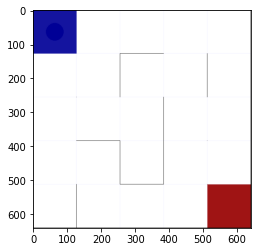

In [ ]:
env = CustomMaze(MazeEnvCast5x5, stochastic_prob=0.9)
action = env.action_space().sample()
observation, reward, done, info = env.step(action)
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')
plt.imshow(env.render('rgb_array'));

### Random actions video 5X5

In [ ]:
make_video(env, 'imageio.mp4', is_random=True)
embed_mp4('imageio.mp4')

took 100 steps


### Note that all our algorithms can be applied for an $n\times n$ maze $\forall n\in \mathbb{N}$!

### Using Dynamic Programming:

In [ ]:
def policy_evaluation(P, policy, gamma, theta, v_init_method=None):
  terminal_state = tuple(env.observation_space().high);
  delta_history = []
  if v_init_method is None:
    v_s = np.zeros(env.maze_size())
  elif v_init_method == 'gaussian':
    v_s = np.random.randn(*env.maze_size())
  elif v_init_method == 'uniform' :
    v_s = np.random.uniform(size=env.maze_size())
  else:
    raise KeyError('v_init_method needs to be one of [None, "uniform", "gaussian"]')

  v_s[terminal_state] = 0

  env.reset()
  v_iters = 0
  while True:
    v_s_next = np.zeros_like(v_s)
    delta = 0
    for i in range(v_s.shape[0]):
      for j in range(v_s.shape[1]):
        if (i,j) == terminal_state:
          continue

        for action, action_probability in enumerate(policy[(i,j)]):
          for transition_probability, next_state, reward, done in P[(i,j)][action]:
            v_s_next[i,j] += action_probability * (transition_probability * (reward + gamma * v_s[next_state]))
        delta = max(delta, np.abs(v_s_next[i,j]- v_s[i,j]))
    v_s = v_s_next.copy()
    v_iters += 1
    delta_history.append(delta)
    if delta < theta:
            break
  return v_s, v_iters, delta_history

In [ ]:
def policy_improvement(v_s, policy, P, gamma):
  for i in range(v_s.shape[0]):
    for j in range(v_s.shape[1]):
      state = (i,j)
      actions_values = defaultdict(int)
      policy[state] = np.zeros(env.action_space().n)
      for action in get_available_actions(env, state):
        for transition_probability, next_state, reward, done in P[(i,j)][action]:
            actions_values[action] += transition_probability * (reward + gamma * v_s[next_state])
      best_action = max(actions_values, key=actions_values.get)
      policy[state][best_action] = 1
  return policy

In [ ]:
def policy_iteration(env, gamma=0.99, theta=0.0000001, v_init_method=None):
  v_iters = 0
  delta_history = []
  P = generate_P(env, transition_p=env.stochastic_prob)
  policy = generate_random_maze_policy(env, uniform=True)
  iterations = 0
  while True:
    v_s, iters, deltas = policy_evaluation(P, policy, gamma, theta, v_init_method)
    v_iters += iters
    delta_history += deltas
    new_policy = policy_improvement(v_s, policy.copy(), P, gamma)
    if np.all(new_policy == policy):
      break
    else:
      policy = new_policy
      iterations += 1
  return v_s, policy, iterations, v_iters, delta_history

In [ ]:
v_s, policy, iterations, v_iters, delta_history = policy_iteration(env, gamma=0.99, theta=0.001)

Let us examine $v_s$ to get a sense of correctness.

In [ ]:
v_s

array([[0.88885597, 0.90225128, 0.91750321, 0.93342593, 0.91858647],
       [0.90374618, 0.8898745 , 0.90376355, 0.94954515, 0.96529122],
       [0.91959759, 0.93450251, 0.91855348, 0.90377882, 0.98119802],
       [0.93503779, 0.95008337, 0.96637338, 0.98178344, 0.99728891],
       [0.94909406, 0.96475887, 0.98065686, 0.99727044, 0.        ]])

Now we test our results. Recall that the env is stochastic, making the results non deterministic.

In [ ]:
make_video(env, 'imageio.mp4', policy=policy)
embed_mp4('imageio.mp4')

took 9 steps


###Experiments Using DP:

####Setting different $v(s)$ initialization:
1. $v(s_i)=0, ∀i$
2. $v(s_i)∼\mathcal{N}(0,1), ∀i$
3. $v(s_i)∼U(0,1), ∀i$

In [ ]:
experiments = 200
thetas = [0.01, 0.001, 0.00001]
data = {}

for theta in thetas:
  _,_,_, v_iters, _ = policy_iteration(env, gamma=0.99, theta=theta)

  v_iters_uniform = v_iters_gaussian = 0
  for i in range(experiments):
    _, _, _, v_it, _ = policy_iteration(env, gamma=0.99, theta=theta, v_init_method='uniform')
    v_iters_uniform += v_it
  v_iters_uniform /= experiments

  for i in range(experiments):
    _, _, _, v_it, _ = policy_iteration(env, gamma=0.99, theta=theta, v_init_method='gaussian')
    v_iters_gaussian += v_it
  v_iters_gaussian /= experiments

  data[theta] = [v_iters, v_iters_uniform, v_iters_gaussian]

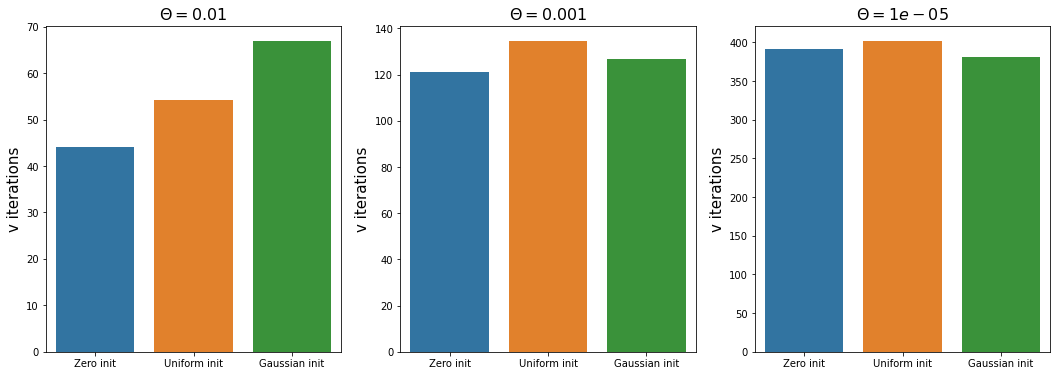

In [ ]:
draw_v_iters(data)

## Environment 15X15

action: 3, observation: [0 0],  reward: -0.00044444444444444447, done: False


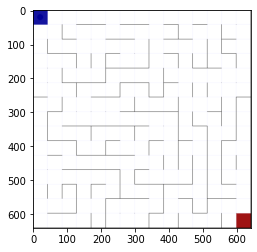

In [ ]:
env = CustomMaze(MazeEnvCast15x15, stochastic_prob=0.9)
action = env.action_space().sample()
observation, reward, done, info = env.step(action)
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')
plt.imshow(env.render('rgb_array'));

### Using Monte Carlo:
Our custom method is a mix between first-visit and every-visit methods. We start with one episode per iteration (average one instance) and continue doing so as long as the agent doesn't reach the terminal state. If he does, we update the policy and require him to do 2 first-visit episodes and average the results before updating the policy again. If he doesn't (reached step limit param), we update the policy immediately to make him take other paths.  In general, as long as the agent reaches the terminal state, we add another episode per iteration and average all first-visits within these episodes before updating the policy again and going to the next iteration.

We found that this method converges much faster than every-visit and is more stable than first-visit.

In [ ]:
def generate_episode(env, policy, step_limit, epsilon):
  states, rewards, actions = [],[],[]
  action_space = np.arange(env.action_space().n)
  state = env.reset().astype(int)

  steps = 1
  while True:
    if np.random.uniform() < epsilon:
      action = np.random.choice(action_space)
    else:
      action = np.random.choice(action_space, p=policy[tuple(state)])

    next_state, reward, is_done, _ = env.step(action)
    states.append(state.astype(int))
    rewards.append(reward)
    actions.append(action)

    if is_done or steps >= step_limit:
      break

    state = next_state.copy()
    steps+=1
  return np.array(states), np.array(rewards), np.array(actions), steps

In [ ]:
def mc_prediction_q(env, policy, num_episodes, step_limit, epsilon, gamma=1):

  returns_sum = defaultdict(lambda: np.zeros(env.action_space().n))
  N = defaultdict(lambda: np.zeros(env.action_space().n))
  Q = defaultdict(lambda: np.zeros(env.action_space().n))
  steps_arr = []
  rewards_hist = []

  for episode in range(num_episodes):
    visited_states = []

    states, rewards, actions, steps = generate_episode(env, policy, step_limit, epsilon)
    rewards_hist.append(sum(rewards))
    steps_arr.append(steps)
    discounts = np.array([gamma ** i for i in range(len(rewards)+1)])
    for i in range(1, len(states)+1):
      state, action = states[-i], actions[-i]

      if list(state) in visited_states:
        continue

      x,y = state
      returns_sum[x,y][action] += np.sum(rewards[-i:]*discounts[:i])
      N[x,y][action] += 1
      Q[x,y][action] = returns_sum[x,y][action] / N[x,y][action]
      visited_states.append(list(state))

  return Q, steps_arr, np.mean(rewards_hist)

Our $ɛ$ decay method takes off 90% of its value at every iteration untill it reaches 0.05.

In [ ]:
def mc_policy_iteration(env, iters=10, gamma=1, epsilon=0.2, decay=False, step_limit=1000, min_steps=30, stable_policy_stop=True, verbose=False):
  steps_history = []
  rewards_history = []
  num_episodes = 1
  total = num_episodes

  policy = generate_random_maze_policy(env)
  for iter in range(iters):
    new_policy = policy.copy()
    Q, steps_arr, avg_reward = mc_prediction_q(env, policy, num_episodes, step_limit, epsilon, gamma)
    rewards_history.append(avg_reward)
    steps_history.append(np.mean(steps_arr))
    if verbose:
      print(f'iter: {iter+1} - took {int(np.mean(steps_arr))} steps on average')

    if decay:
      epsilon = max(epsilon*0.9, 0.05)

    for state in Q:
      argmax = Q[state].argmax()
      new_policy[state] = np.zeros(env.action_space().n)
      new_policy[state][argmax] = 1

    # if stable_policy_stop and np.all(policy == new_policy):
    #   print(epsilon)
    #   break
    policy = new_policy
    if np.min(steps_arr) < step_limit and num_episodes < 7:
      num_episodes += 1
    total += num_episodes
    if verbose == 'minimal':
      print(f'total {total} episodes')
  return policy, Q, steps_history, rewards_history

In [ ]:
np.random.seed(10)
p, q, steps_history_mc, rewards_history_mc = mc_policy_iteration(env, iters=50, gamma=0.999, epsilon=0.5, decay=True, step_limit=10000, verbose=True)

iter: 1 - took 10000 steps on average
iter: 2 - took 4121 steps on average
iter: 3 - took 115 steps on average
iter: 4 - took 236 steps on average
iter: 5 - took 100 steps on average
iter: 6 - took 133 steps on average
iter: 7 - took 464 steps on average
iter: 8 - took 169 steps on average
iter: 9 - took 159 steps on average
iter: 10 - took 190 steps on average
iter: 11 - took 93 steps on average
iter: 12 - took 146 steps on average
iter: 13 - took 107 steps on average
iter: 14 - took 90 steps on average
iter: 15 - took 53 steps on average
iter: 16 - took 41 steps on average
iter: 17 - took 39 steps on average
iter: 18 - took 42 steps on average
iter: 19 - took 130 steps on average
iter: 20 - took 98 steps on average
iter: 21 - took 74 steps on average
iter: 22 - took 117 steps on average
iter: 23 - took 94 steps on average
iter: 24 - took 40 steps on average
iter: 25 - took 39 steps on average
iter: 26 - took 41 steps on average
iter: 27 - took 88 steps on average
iter: 28 - took 41 s

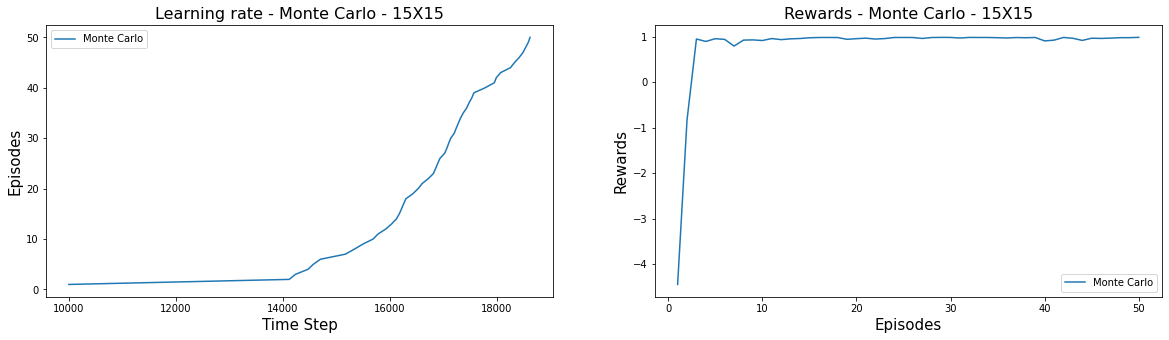

In [ ]:
draw_rewards_and_steps_graph({"Monte Carlo":steps_history_mc}, {"Monte Carlo":rewards_history_mc},'Learning rate - Monte Carlo - 15X15', 'Rewards - Monte Carlo - 15X15')

In [ ]:
env = CustomMaze(MazeEnvCast15x15, stochastic_prob=0.9)
make_video(env, '15x15.mp4', p)
embed_mp4('15x15.mp4')

took 41 steps


The following experiment consists of running MC 10 times (seperately) with and without epsilon-decay.

The results imply that our decay method does a great job!

In [ ]:
experiments = 10
agg_steps, agg_rewards = [],[]
agg_steps_decay, agg_rewards_dacay = [],[]

for exper in range(experiments):
  p, q, steps_history, rewards_history = mc_policy_iteration(env, iters=50, gamma=0.999, epsilon=0.1, decay=False, step_limit=10000, stable_policy_stop=False)
  p, q, steps_history_decay, rewards_history_decay = mc_policy_iteration(env, iters=50, gamma=0.999, epsilon=0.5, decay=True, step_limit=10000, stable_policy_stop=False)
  for agg, res in zip([agg_steps, agg_rewards, agg_steps_decay, agg_rewards_dacay], [steps_history, rewards_history,steps_history_decay, rewards_history_decay]):
    agg.append(res)

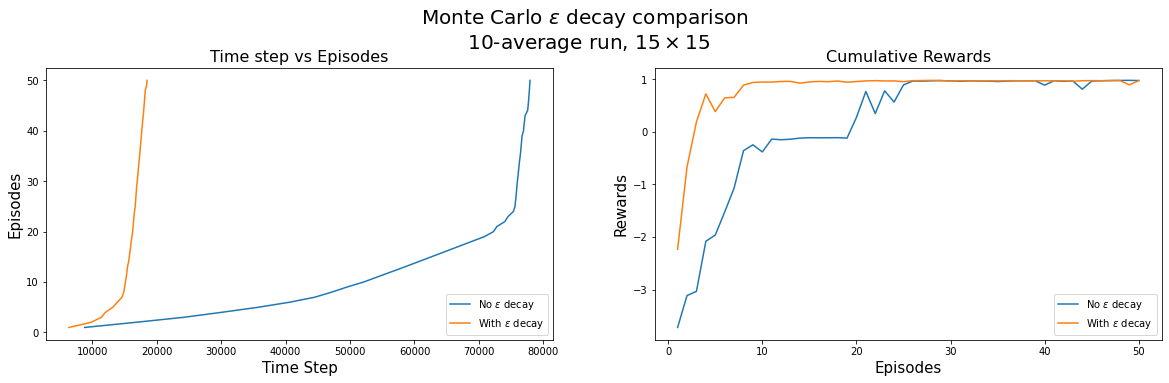

In [ ]:
steps_dict = {"No $\\varepsilon$ decay":np.array(agg_steps).mean(axis=0), "With $\\varepsilon$ decay": np.array(agg_steps_decay).mean(axis=0)}
rewards_dict = {"No $\\varepsilon$ decay":np.array(agg_rewards).mean(axis=0), "With $\\varepsilon$ decay": np.array(agg_rewards_dacay).mean(axis=0)}
draw_rewards_and_steps_graph(steps_dict, rewards_dict,'Time step vs Episodes', 'Cumulative Rewards')
plt.suptitle(f'Monte Carlo $\\varepsilon$ decay comparison \n {experiments}-average run, $15 \\times 15$', size=20, y=1.05);

Now we proceed to tune the discount factor, using $ɛ$ greedy policy.

In [ ]:
experiments = 5
gammas = [0.9, 0.99, 0.999, 1]
gamma_results = {gamma: {} for gamma in gammas}
for gamma in gammas:
  agg_steps, agg_rewards = [],[]
  for exper in range(experiments):
    _, _, steps_history, rewards_history = mc_policy_iteration(env, iters=50, gamma=gamma, epsilon=0.5, decay=True, step_limit=10000, stable_policy_stop=False)
    agg_steps.append(steps_history)
    agg_rewards.append(rewards_history)
  gamma_results[gamma]['steps_history'] = np.array(agg_steps).mean(axis=0)
  gamma_results[gamma]['rewards_history'] = np.array(agg_rewards).mean(axis=0)


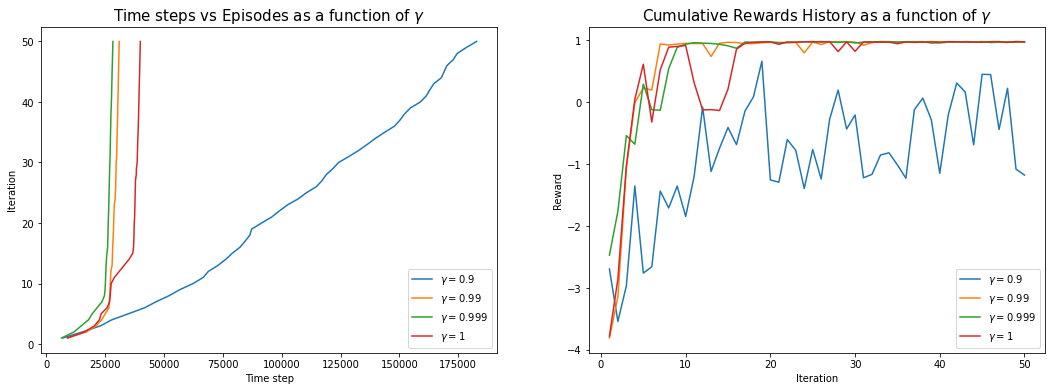

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

for gamma in gammas:
  ax[0].plot(np.cumsum(gamma_results[gamma]['steps_history']), np.arange(1,len(gamma_results[gamma]['steps_history'])+1), label=f'$\\gamma=${gamma}')
  ax[1].plot(np.arange(1,len(gamma_results[gamma]['rewards_history'])+1), gamma_results[gamma]['rewards_history'], label=f'$\\gamma=${gamma}')
  ax[0].set_title('Time steps vs Episodes as a function of $\gamma$', size=15)
  ax[1].set_title('Cumulative Rewards History as a function of $\gamma$', size=15)
  ax[0].legend(), ax[1].legend()
ax[0].set_xlabel('Time step'), ax[1].set_xlabel('Iteration');
ax[0].set_ylabel('Iteration'), ax[1].set_ylabel('Reward');

### Using Q-Learning & SARSA:
Not the difference between the two methods when choosing next Q.

In [ ]:
def run_game_q_learning(env, q_table, step_limit, epsilon, lr, gamma, SARSA=False):
  action_space = np.arange(env.action_space().n)
  state = env.reset().astype(int)
  rewards = 0
  steps = 1
  while True:
    if np.random.uniform() < epsilon:
      action = np.random.choice(action_space)
    else:
      action = q_table[tuple(state)].argmax()

    next_state, reward, is_done, _ = env.step(action)

    next_q = q_table[next_state[0], next_state[1], action] if SARSA else q_table[tuple(next_state)].max()
    curr_q = q_table[state[0], state[1], action]

    new_curr_q = (1-lr) * curr_q + lr * (reward + gamma * next_q)
    q_table[state[0], state[1], action] = new_curr_q
    rewards += reward
    if is_done or steps >= step_limit:
      break

    state = next_state.copy()
    steps+=1
  return steps, rewards


In [ ]:
def run_q_learning(env, epsilon, step_limit, episodes=500, lr=0.1, gamma=0.999, SARSA=False, decay=False, verbose=True):
  step_history = []
  reward_history = []
  episode_doc_amt = episodes // 10
  q_table = np.zeros(list(env.observation_space().high +1) + [env.action_space().n])
  middle_q = None
  for episode in range(1, episodes+1):
    steps, rewards = run_game_q_learning(env, q_table, step_limit, epsilon, lr, gamma)
    step_history.append(steps)
    reward_history.append(rewards)
    if decay:
      epsilon = max(epsilon*0.99, 0.05)
    if verbose:
      if episode % episode_doc_amt == 0:
        avg_steps = int(np.mean(step_history[episode-episode_doc_amt: episode]))
        print(f'{episode} episides: {avg_steps} avg steps')
    if episode == episodes//2:
      middle_q = copy.deepcopy(q_table)
  return q_table, step_history, reward_history, middle_q

In [ ]:
np.random.seed(10)
q_table_q_learning, step_history_q_learning, reward_history_q_learning, middle_q = run_q_learning(env, epsilon=0.5, lr=0.25, gamma=0.999, decay=True, step_limit=100000, episodes=500)

50 episides: 687 avg steps
100 episides: 151 avg steps
150 episides: 44 avg steps
200 episides: 36 avg steps
250 episides: 35 avg steps
300 episides: 35 avg steps
350 episides: 39 avg steps
400 episides: 35 avg steps
450 episides: 35 avg steps
500 episides: 35 avg steps


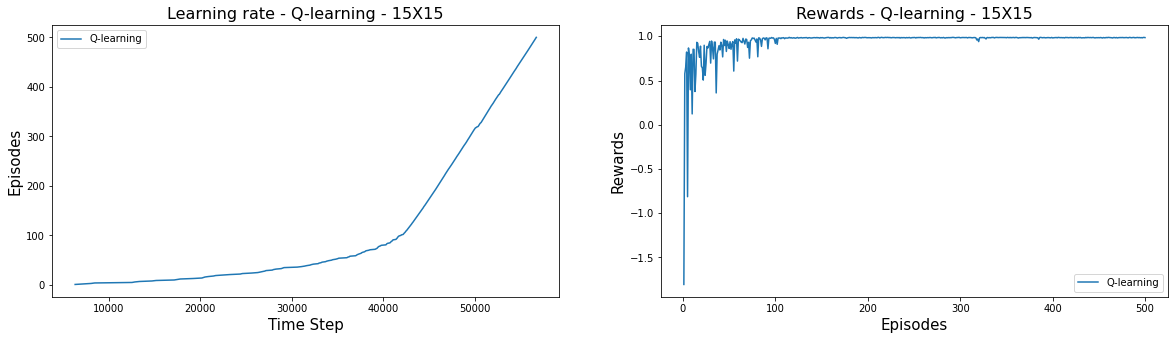

In [ ]:
draw_rewards_and_steps_graph({"Q-learning":step_history_q_learning}, {"Q-learning":reward_history_q_learning},'Learning rate - Q-learning - 15X15', 'Rewards - Q-learning - 15X15')

####Q-learning video - halfway during the training process:

In [ ]:
make_video(env, 'Q_learning_middle_15x15.mp4', middle_q)
embed_mp4('Q_learning_middle_15x15.mp4')

took 35 steps


####Q-learning video - At the end of the training process:

In [ ]:
make_video(env, 'Q_learning_15x15.mp4', q_table_q_learning)
embed_mp4('Q_learning_15x15.mp4')

took 32 steps


#### Experiments Using Q-Learning:

In [ ]:
def run_search_grid(sarsa):
  lrs = [0.1, 0.25, 0.5]
  epsilons = [0.05, 0.1, 0.2]
  decays = [True, False]
  gammas = [0.9, 0.99, 0.999, 1]
  results = {}
  top_rewards_model = {}
  top_steps_model = {}
  best_rewards = 0
  best_steps = np.inf
  for lr in lrs:
    for epsilon in epsilons:
      for decay in decays:
        for gamma in gammas:
          print(f'Running Experiment with lr: {lr}, decay: {decay}, epsilon: {epsilon}, gamma: {gamma}')
          q_table, step_history, reward_history, middle_q = \
          run_q_learning(env, epsilon=epsilon, lr=lr, gamma=gamma, step_limit=10000, episodes=300, SARSA=sarsa, decay=decay, verbose = False)
          results[(lr, epsilon, gamma, decay)] = (step_history, reward_history)
          if sum(reward_history[-30:]) / 30 == best_rewards:
            top_rewards_model[(lr, epsilon, gamma)] = reward_history
          elif  sum(reward_history[-30:]) / 30 > best_rewards:
            top_rewards_model = {}
            top_rewards_model[(lr, epsilon, gamma)] = reward_history
            best_rewards = sum(reward_history[-30:]) / 30

          if sum(step_history[-30:]) / 30 == best_steps:
            top_steps_model[(lr, epsilon, gamma)] = step_history
          elif  sum(step_history[-30:]) / 30 < best_steps:
            top_steps_model = {}
            top_steps_model[(lr, epsilon, gamma)] = step_history
            best_steps = sum(step_history[-30:]) / 30
  return results, top_steps_model, top_steps_model

In [ ]:
results_q_learning, top_rewards_model_q_learning, top_steps_model_q_learning = run_search_grid(sarsa = False)

Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 0.9
Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 0.99
Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 0.999
Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 1
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 0.9
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 0.99
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 0.999
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 1
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 0.9
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 0.99
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 0.999
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 1
Running Experiment with lr: 0.1, decay: False, epsilon: 0.1, gamma: 0.9
Running Experiment with lr: 0.1, decay: False, epsilon: 0.1, 

In [ ]:
improved_results_q_learning = copy.deepcopy(results_q_learning)
for key in improved_results_q_learning.keys():
  improved_results_q_learning[key] = improved_results_q_learning[key] + (np.mean(improved_results_q_learning[key][0][-30:]),)

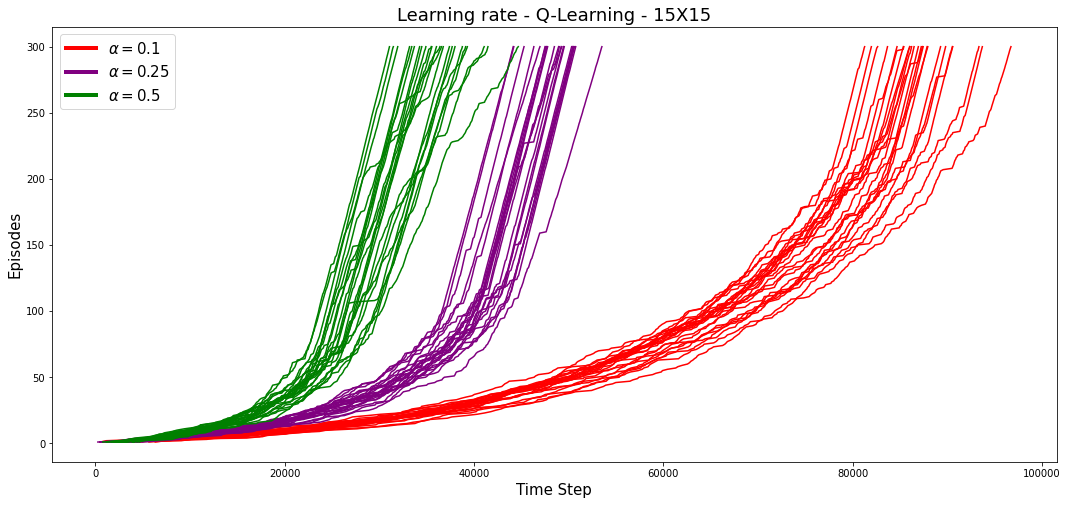

In [ ]:
create_graphs(results_q_learning , 'Q-Learning')

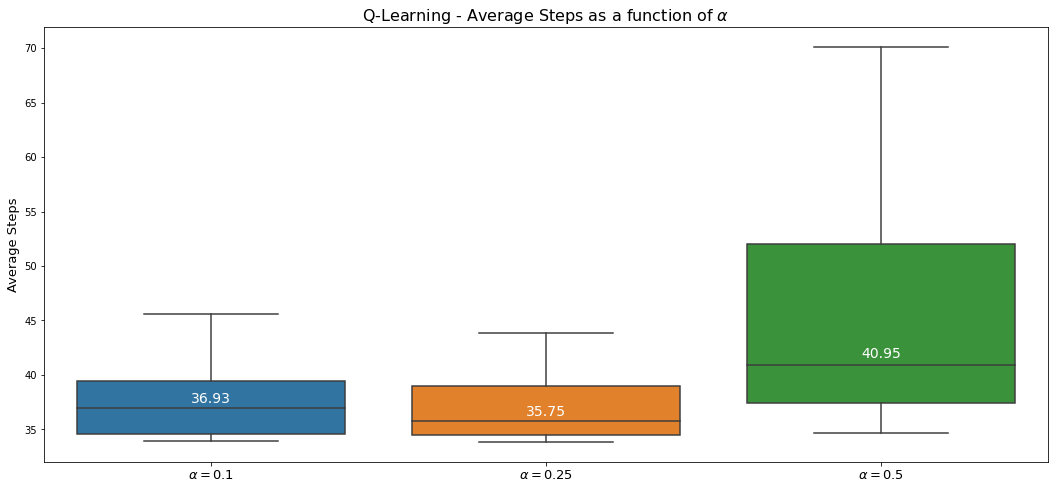

In [ ]:
create_boxplot(improved_results_q_learning, 'Q-Learning')

In [ ]:
filtered_results = {k: v for k, v in results_q_learning.items() if k[0]==0.25}

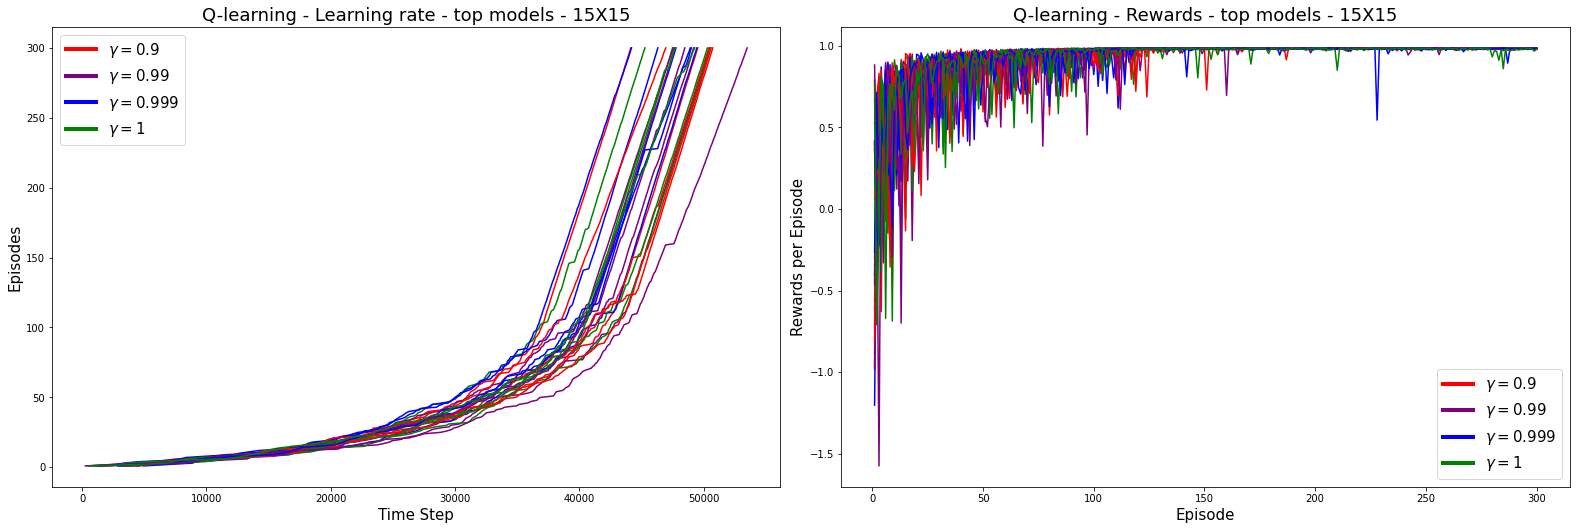

In [ ]:
plt.figure(figsize=(22,14))
plt.subplot(2, 2, 1)
color_map = {0.9: 'red', 0.99: 'purple', 0.999: 'blue', 1: 'green'}
for lr, epsilon, gamma, decay in filtered_results:
  steps = results_q_learning[(lr, epsilon, gamma, decay)][0]
  plt.plot(np.cumsum(steps), np.arange(1,len(steps)+1), label=f'lr: {lr}, epsilon: {epsilon}, gamma: {gamma}, decay: {decay}', color=color_map[gamma])
  plt.xlabel('Time Step', size=15), plt.ylabel('Episodes', size=15)
  plt.title(f'Q-learning - Learning rate - top models - 15X15', size=18)
plt.legend(handles=[Line2D([0], [0], color=c, lw=4, label=f'$\\gamma={lr}$') for lr ,c in color_map.items()], prop={'size': 15})

plt.subplot(2, 2, 2)
for lr, epsilon, gamma, decay in filtered_results:
  rewards = results_q_learning[(lr, epsilon, gamma, decay)][1]
  plt.plot(np.arange(1,len(rewards)+1), rewards, label=f'$\\varepsilon: {epsilon}, \gamma: {gamma}$, decay: {decay}', color=color_map[gamma])
plt.legend(handles=[Line2D([0], [0], color=c, lw=4, label=f'$\\gamma={lr}$') for lr ,c in color_map.items()], prop={'size': 15})
plt.xlabel('Episode', size=15)
plt.ylabel('Rewards per Episode', size=15)
plt.title(f'Q-learning - Rewards - top models - 15X15', size=18)
plt.tight_layout()

#### Using SARSA:

In [ ]:
q_table_sarsa, step_history_sarsa, reward_history_sarsa, middle_q_sarsa = run_q_learning(env, epsilon=0.5, lr=0.25, gamma=0.999, decay=True, step_limit=100000, episodes=500, SARSA=True)

50 episides: 621 avg steps
100 episides: 132 avg steps
150 episides: 46 avg steps
200 episides: 36 avg steps
250 episides: 35 avg steps
300 episides: 35 avg steps
350 episides: 35 avg steps
400 episides: 35 avg steps
450 episides: 40 avg steps
500 episides: 35 avg steps


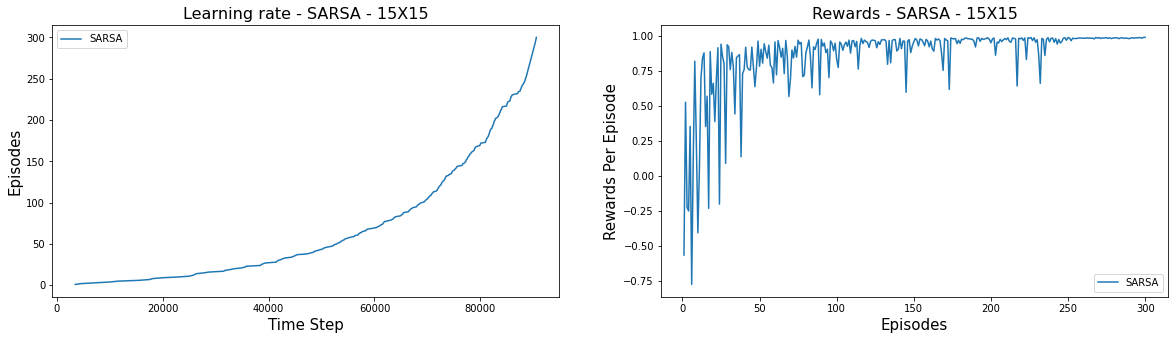

In [ ]:
draw_rewards_and_steps_graph({"SARSA":step_history_sarsa}, {"SARSA":reward_history_sarsa},'Learning rate - SARSA - 15X15', 'Rewards - SARSA - 15X15')

####SARSA video - halfway during the training process:

In [ ]:
env = CustomMaze(MazeEnvCast15x15, stochastic_prob=0.9)
make_video(env, 'SARSA_middle_15x15.mp4', middle_q_sarsa)
embed_mp4('SARSA_middle_15x15.mp4')

took 33 steps


####SARSA video - At the end of the training process:

In [ ]:
make_video(env, 'SARSA_15x15.mp4', q_table_sarsa)
embed_mp4('SARSA_15x15.mp4')

took 32 steps


####Experiments Using SARSA:

In [ ]:
results_sarsa, top_rewards_model_sarsa, top_steps_model_sarsa = run_search_grid(sarsa = True)

Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 0.9
Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 0.99
Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 0.999
Running Experiment with lr: 0.1, decay: True, epsilon: 0.05, gamma: 1
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 0.9
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 0.99
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 0.999
Running Experiment with lr: 0.1, decay: False, epsilon: 0.05, gamma: 1
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 0.9
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 0.99
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 0.999
Running Experiment with lr: 0.1, decay: True, epsilon: 0.1, gamma: 1
Running Experiment with lr: 0.1, decay: False, epsilon: 0.1, gamma: 0.9
Running Experiment with lr: 0.1, decay: False, epsilon: 0.1, 

In [ ]:
improved_results = copy.deepcopy(results_sarsa)
for key in improved_results.keys():
  improved_results[key] = improved_results[key] + (np.mean(improved_results[key][0][-30:]),)

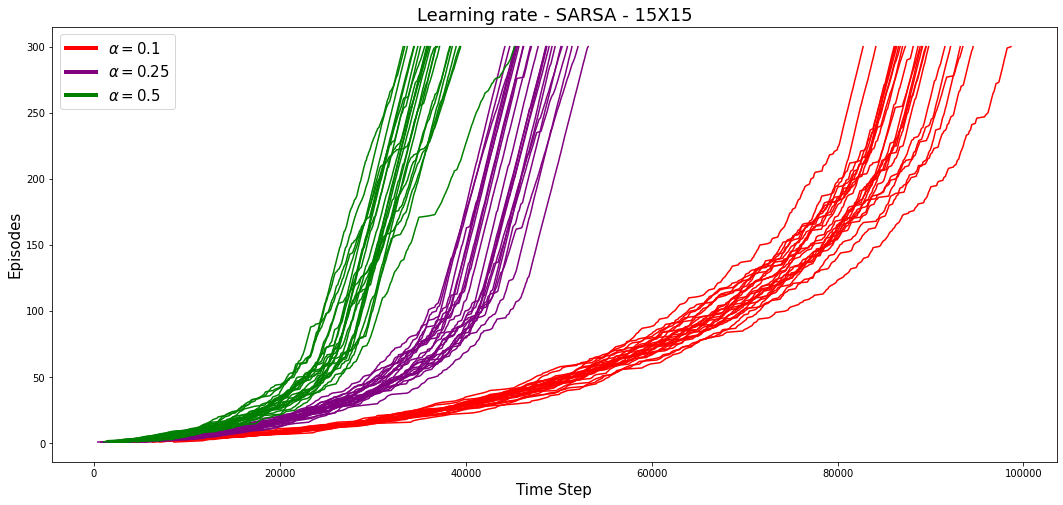

In [ ]:
create_graphs(results_sarsa , 'SARSA')

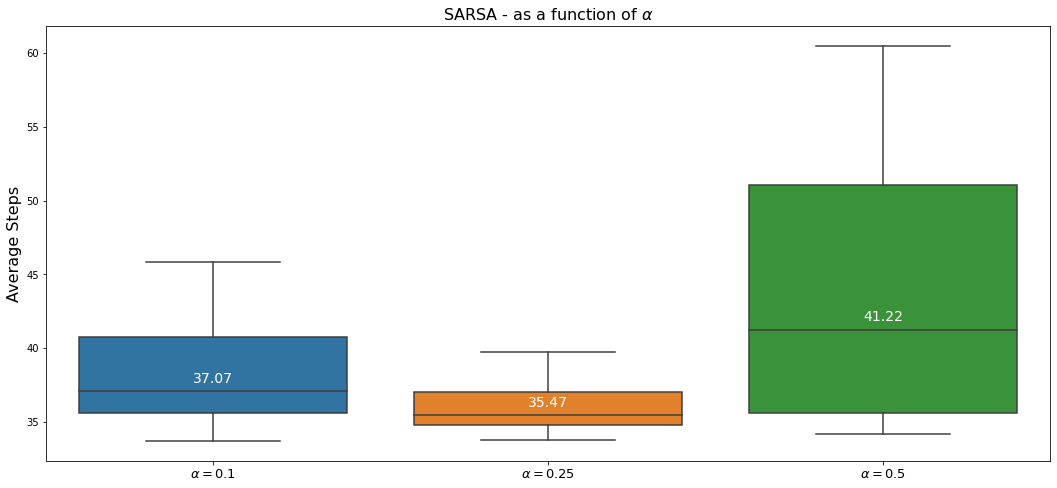

In [ ]:
create_boxplot(improved_results, "SARSA")

####Comparison between Q-learning and SARSA:

In [ ]:
experiments = 10
agg_steps, agg_rewards = [],[]
agg_steps_sarsa, agg_rewards_sarsa = [],[]

for exper in range(experiments):
  _, steps_history_sarsa, rewards_history_sarsa, _ = run_q_learning(env, epsilon=0.5, lr=0.25, decay=True, gamma=0.999, step_limit=10000, episodes=500, SARSA=True, verbose=False)
  _, steps_history, rewards_history, _ = run_q_learning(env, epsilon=0.5, decay=True, lr=0.25, gamma=0.999, step_limit=10000, episodes=500, SARSA=False, verbose=False)
  for agg, res in zip([agg_steps, agg_rewards, agg_steps_sarsa, agg_rewards_sarsa], [steps_history, rewards_history,steps_history_sarsa, rewards_history_sarsa]):
    agg.append(res)

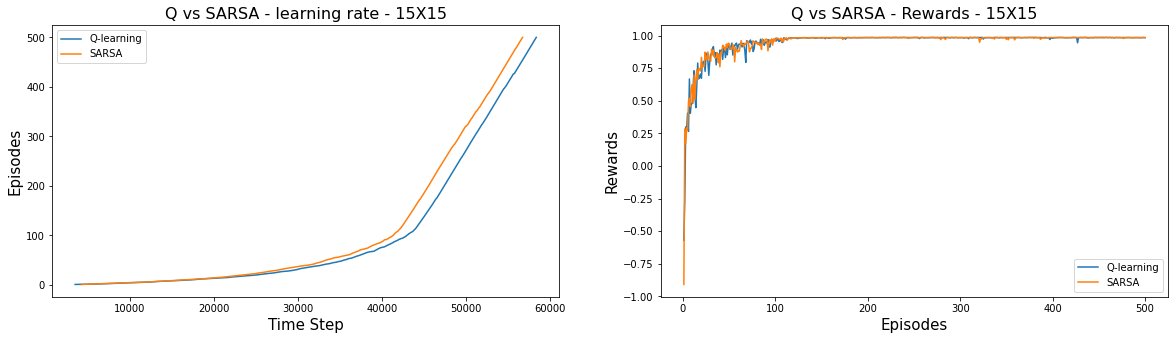

In [ ]:
steps_dict = {"Q-learning": np.array(agg_steps).mean(axis=0), "SARSA": np.array(agg_steps_sarsa).mean(axis=0)}
rewards_dict = {"Q-learning": np.array(agg_rewards).mean(axis=0), "SARSA": np.array(agg_rewards_sarsa).mean(axis=0)}
draw_rewards_and_steps_graph(steps_dict, rewards_dict, "Q vs SARSA - learning rate - 15X15", "Q vs SARSA - Rewards - 15X15")

## Environment 25X25

action: 3, observation: [0 0],  reward: -0.00016, done: False


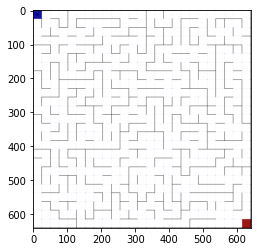

In [ ]:
env = CustomMaze(MazeEnvCast25x25, stochastic_prob=0.9)
action = env.action_space().sample()
observation, reward, done, info = env.step(action)
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')
plt.imshow(env.render('rgb_array'));

###Using DP

Using Dynamic Programming, we can solve the $25\times25$ maze in just about 10 seconds, without modifying cell rewards. The result converges to a 54-steps walking path using a deterministic transition model.

In [ ]:
start_time = time.time()
v_s, policy, iterations, v_iters, delta_history = policy_iteration(env, gamma=0.99, theta=0.001, v_init_method=None)
runtime_DP = time.time() - start_time

In [ ]:
env = CustomMaze(MazeEnvCast25x25, stochastic_prob=0.9)
make_video(env, 'DP_25x25.mp4', policy)
embed_mp4('DP_25x25.mp4')

took 57 steps


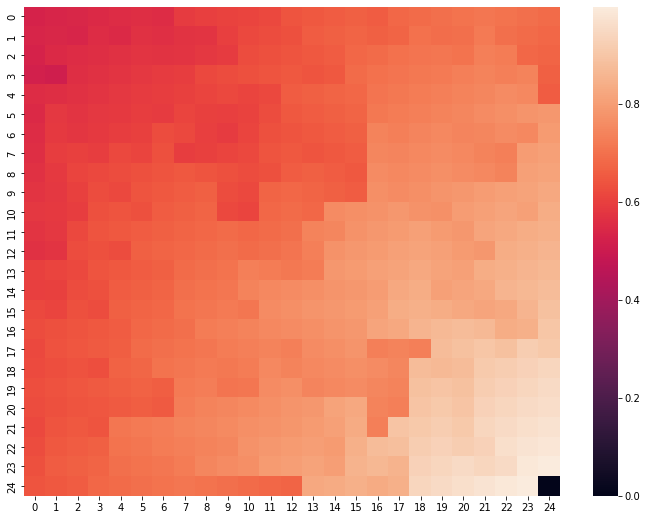

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(v_s);

#### DP - Experiments

In [ ]:
data = {}
gammas = [0.95,0.99,0.995,0.999,0.9999,1]
for gamma in gammas:
  _, _, _, v_iters, delta_history = policy_iteration(env, gamma=gamma, theta=0.001)
  data[gamma] = v_iters, delta_history

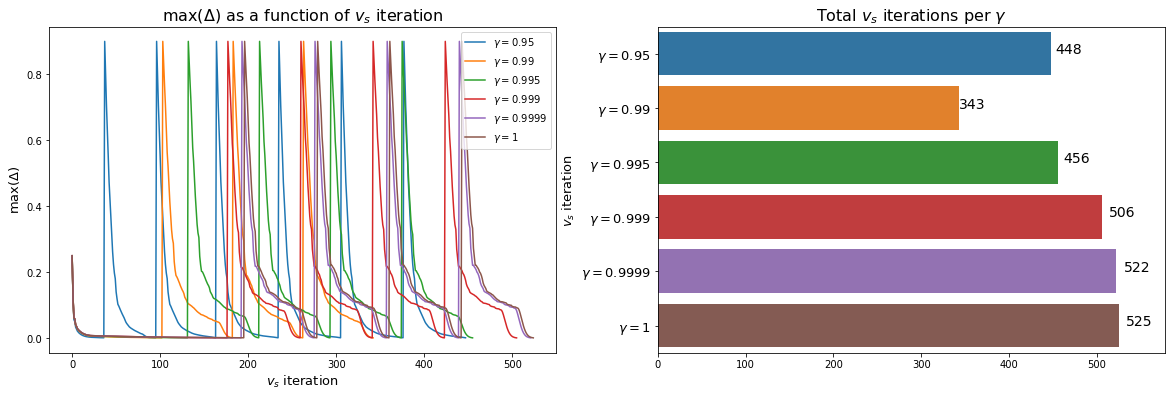

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
for gamma in gammas:
  ax[0].plot(data[gamma][1], label=f'$\\gamma={gamma}$')

g = sns.barplot([data[gamma][0] for gamma in gammas], gammas, ax=ax[1], orient='h')
g.set_yticklabels([f'$\\gamma={gamma}$' for gamma in gammas], size=13);
ax[0].set_title('$\max(\Delta)$ as a function of $v_s$ iteration', size=16)
ax[0].set_xlabel('$v_s$ iteration', size=13), ax[0].set_ylabel('$\max(\Delta)$', size=13)
ax[1].set_ylabel('$v_s$ iteration', size=13)
ax[1].set_title('Total $v_s$ iterations per $\\gamma$', size=16)
ax[0].legend(loc='upper right')
for y,x in enumerate([data[gamma][0] for gamma in gammas]):
  g.text(1.045*x, y, x, color='black', ha='center', size=14)
ax[1].set_xlim([0,1.1*max([data[gamma][0] for gamma in gammas])+0]);

###Using SARSA

In [ ]:
np.random.seed(42)
q_table_sarsa, step_history_sarsa, reward_history_sarsa, middle_q_sarsa= run_q_learning(env, epsilon=0.5, lr=0.25, gamma=0.999, decay=True, step_limit=10000, episodes=500, SARSA=True)

50 episides: 2097 avg steps
100 episides: 724 avg steps
150 episides: 474 avg steps
200 episides: 323 avg steps
250 episides: 261 avg steps
300 episides: 176 avg steps
350 episides: 124 avg steps
400 episides: 74 avg steps
450 episides: 77 avg steps
500 episides: 70 avg steps


SARSA video - halfway during the training process:

In [ ]:
env = CustomMaze(MazeEnvCast25x25, stochastic_prob=0.9)
make_video(env, 'SARSA_middle_25x25.mp4', middle_q_sarsa)
embed_mp4('SARSA_middle_25x25.mp4')

took 62 steps


SARSA video - at the end of the training process:

In [ ]:
env = CustomMaze(MazeEnvCast25x25, stochastic_prob=0.9)
make_video(env, 'SARSA_25x25.mp4', q_table_sarsa)
embed_mp4('SARSA_25x25.mp4')

took 67 steps


In [ ]:
start_time = time.time()
experiments = 10
agg_steps, agg_rewards, agg_q = [],[],[]

for exper in range(experiments):
  q_table, steps_history_sarsa, rewards_history_sarsa, _ = run_q_learning(env, epsilon=0.5, lr=0.25, decay=True, gamma=0.999, step_limit=10000, episodes=500, SARSA=True, verbose=False)
  agg_steps.append(steps_history_sarsa)
  agg_rewards.append(rewards_history_sarsa)
  agg_q.append(q_table)

average_runtime_sarsa = (time.time() - start_time)/10

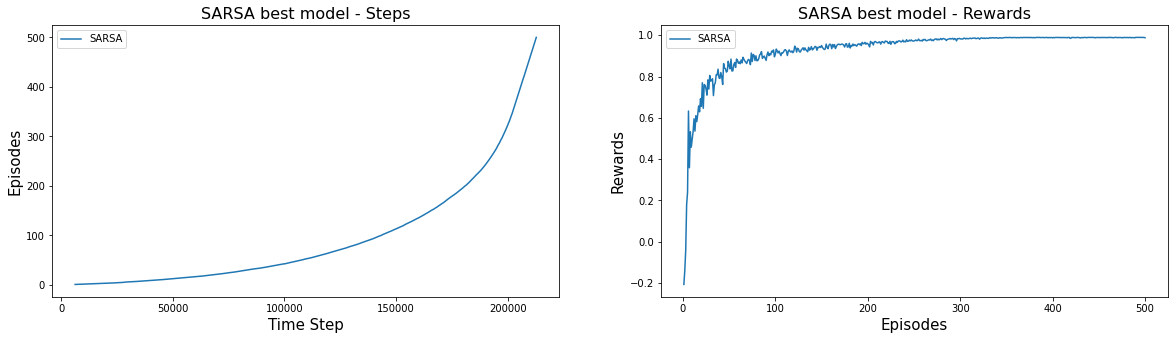

In [ ]:
steps_dict = {"SARSA": np.array(agg_steps).mean(axis=0)}
rewards_dict = {"SARSA": np.array(agg_rewards).mean(axis=0)}
draw_rewards_and_steps_graph(steps_dict, rewards_dict, "SARSA best model - Steps", "SARSA best model - Rewards")

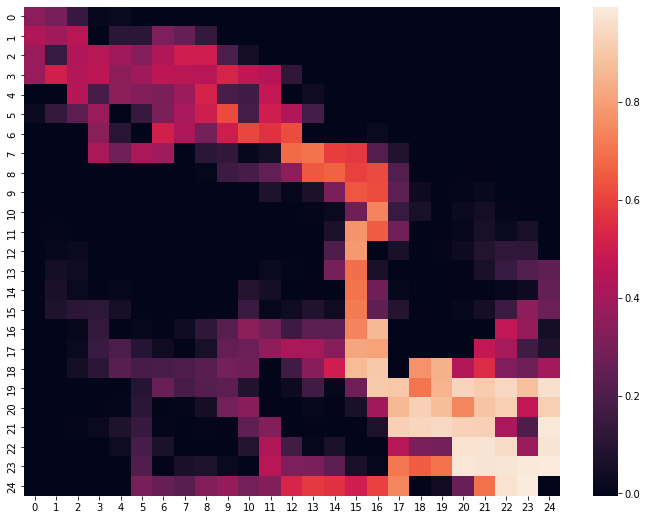

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(np.array(agg_q).mean(3).max(0).T);

###Comparing Runtime  - DP VS SARSA

In [ ]:
print(f'Running time for DP:{runtime_DP:.2f} seconds')
print(f'Running time for SARSA: {average_runtime_sarsa:.2f} seconds')

Running time for DP:4.52 seconds
Running time for SARSA: 28.08 seconds


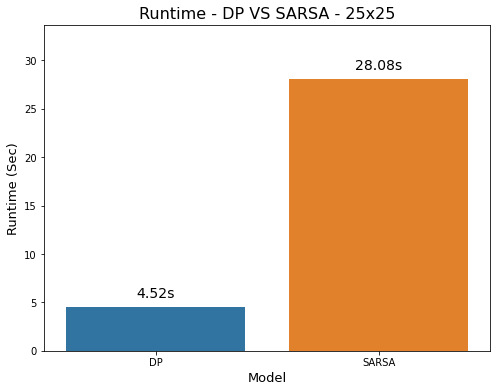

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x=["DP", "SARSA"], y=[round(runtime_DP,2), round(average_runtime_sarsa,2)])
ax.set_xlabel("Model", size=13)
ax.set_ylabel("Runtime (Sec)", size=13)
ax.set_title("Runtime - DP VS SARSA - 25x25", size=16)
ax.set_ylim([0,1.2*max(average_runtime_sarsa, runtime_DP)])
for x, value in enumerate([runtime_DP, average_runtime_sarsa]):
  ax.text(x, value+1, str(round(value, 2))+ 's', color='black', ha='center', size=14)

### DP - Positive and Negative Rewards

In [ ]:
good_rewards = [None, (5,20), (16,18)]
bad_rewards = [None, (11,6), (12,24)]
results = {}
for good_reward in good_rewards:
  for bad_reward in bad_rewards:
    env = CustomMaze(MazeEnvCast25x25, stochastic_prob=0.9, reward_cell=good_reward, punishment_cell=bad_reward)
    q_table, step_history, reward_history, middle_q = run_q_learning(env, epsilon=0.5, decay=True, lr=0.25, gamma=0.99, step_limit=10000, episodes=500, SARSA=True, verbose=False)
    results[good_reward, bad_reward] = (q_table, step_history, reward_history)

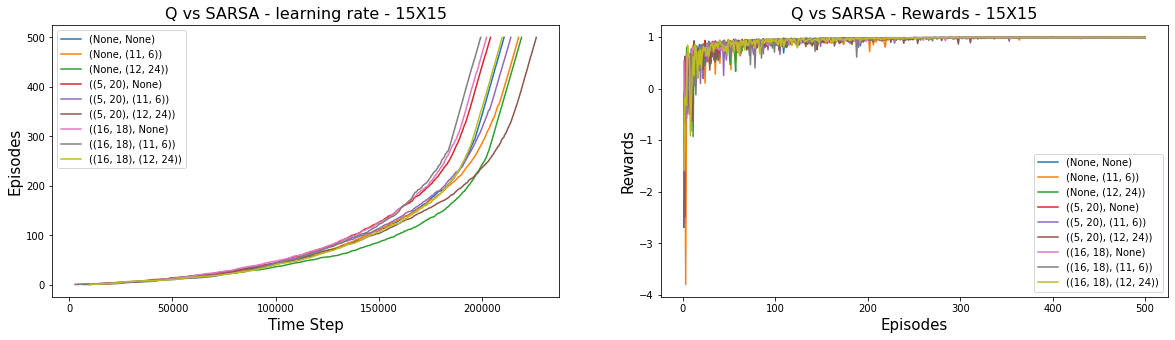

In [ ]:
steps_dict = {k: v[1] for k,v in results.items()}
rewards_dict = {k: v[2] for k,v in results.items()}
draw_rewards_and_steps_graph(steps_dict, rewards_dict, "Q vs SARSA - learning rate - 15X15", "Q vs SARSA - Rewards - 15X15")

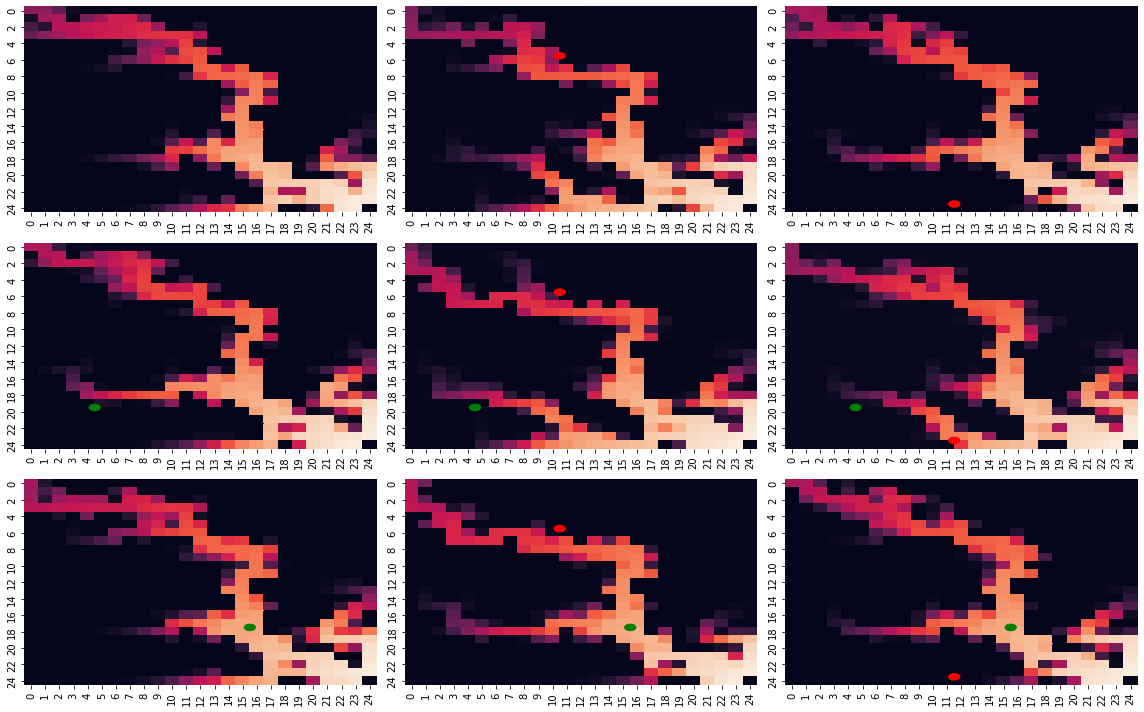

In [ ]:
from matplotlib.patches import Circle, Rectangle

fig, ax = plt.subplots(3,3, figsize=(16,10))
for i in range(len(good_rewards)):
  for j in range(len(bad_rewards)):
    table = results[good_rewards[i], bad_rewards[j]][0].max(2)
    sns.heatmap(table.T, ax=ax[i,j], cbar=False)
    if good_rewards[i] is not None:
      ax[i,j].add_patch(Circle(good_rewards[i], 0.4, edgecolor='green', facecolor='green', fill=True))
    if bad_rewards[j] is not None:
      ax[i,j].add_patch(Circle(bad_rewards[j], 0.4, edgecolor='red', facecolor='red', fill=True))
plt.tight_layout()

###DP - video with best positive and negative Rewards locations

In [ ]:
env = CustomMaze(MazeEnvCast25x25, stochastic_prob=0.9, reward_cell=(16,18), punishment_cell=(11,6))
make_video(env, 'q_learning_25x25.mp4', results[(16,18),(11,6)][0])
embed_mp4('q_learning_25x25.mp4')

took 63 steps
